In [12]:
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import datetime as dt

from common.conics import plot_conics
from src.common.data import DataGenerator

In [2]:
# Ensure SurRender is running
generator = DataGenerator.from_robbins_dataset(resolution=2048, diamlims=(30, 500), arc_lims=0)

Surrender Python Client
code revision : c17439eea9ae041bf49364d67a2a232fc89c1faa


In [3]:
# Generate camera above Tycho (43.31°S 11.36°W) [https://en.wikipedia.org/wiki/Tycho_(lunar_crater)]

generator.set_coordinates(lat=-43.31, long=-11.36, convert_to_radians=True)
generator.scene_time = dt.datetime(2021, 2, 3, 12)
generator.height = 140
generator.point_nadir()
generator.solar_incidence_angle

69.68366967007213

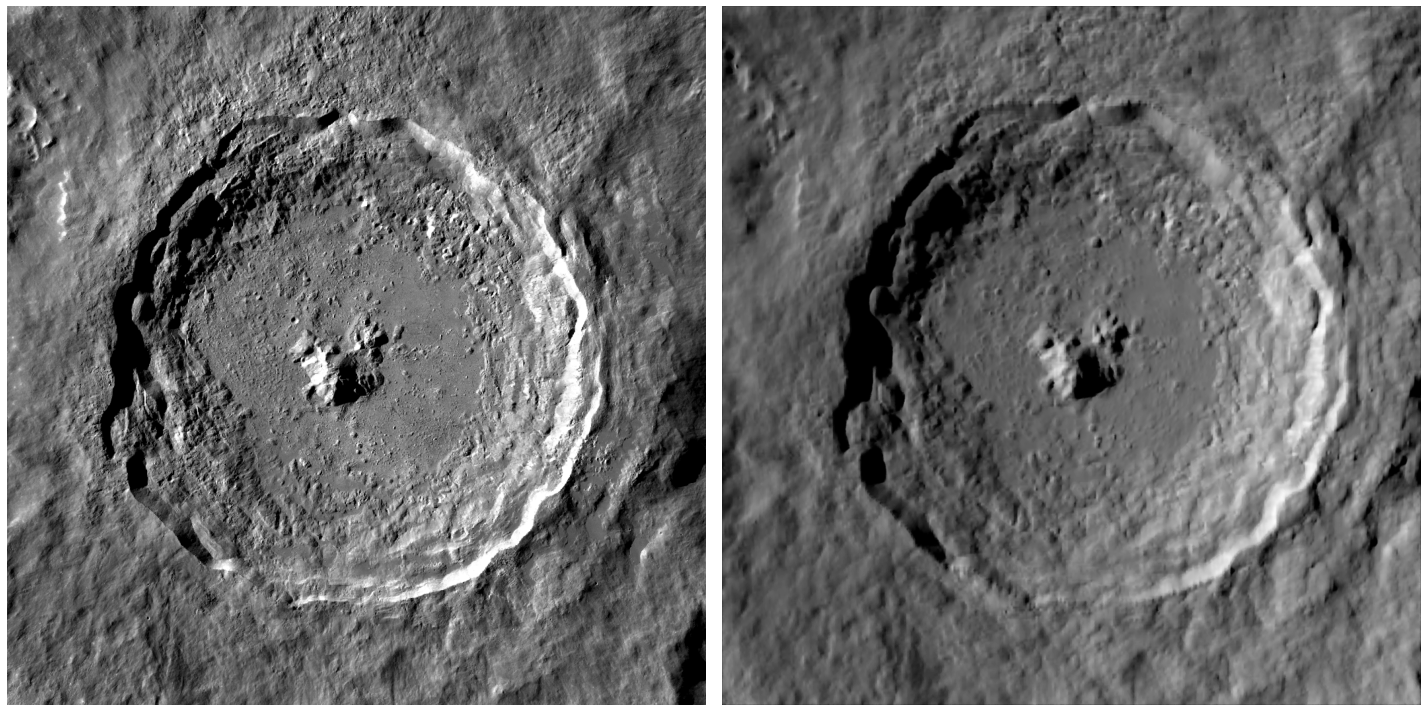

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

tycho_real = mpimg.imread('data/Tycho_LRO.png')
axes[0].imshow(tycho_real, cmap='gray')
axes[0].axis('off')

tycho_sim = generator.generate_image()
axes[1].imshow(tycho_sim, cmap='gray')
axes[1].axis('off')

fig.tight_layout()
# fig.savefig('diagrams/tycho_comparison.png')

In [5]:
# New scene
generator.set_coordinates(lat=0, long=180, convert_to_radians=True)
generator.scene_time = dt.datetime(2021, 1, 19, 12)
generator.height = 3000
generator.point_nadir()
generator.solar_incidence_angle

72.11468853248124

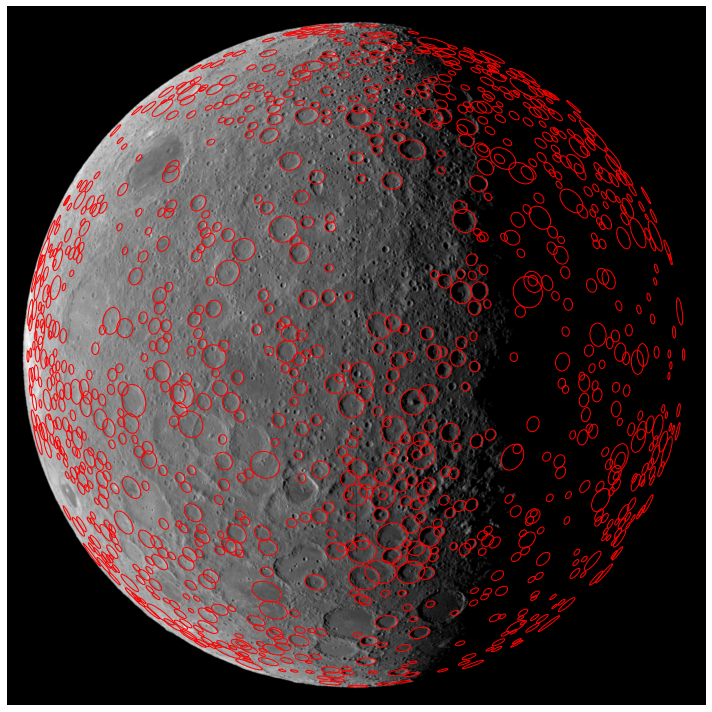

In [6]:
fig, ax= plt.subplots(figsize=(10, 10))

high_alt = generator.generate_image()
ax.imshow(high_alt, cmap='gray')
ax.axis('off')

generator.plot(ax=ax)

fig.tight_layout()
fig.savefig('diagrams/ellipse_plot_example.png')

In [10]:
generator = DataGenerator.from_robbins_dataset(resolution=512, diamlims=(15, 150), arc_lims=0, ellipse_limit=1.5)

Surrender Python Client
code revision : c17439eea9ae041bf49364d67a2a232fc89c1faa


In [11]:
generator.set_coordinates(lat=0, long=160, convert_to_radians=True)
generator.scene_time = dt.datetime(2021, 1, 19, 12)
generator.height = 500
generator.point_nadir()
generator.solar_incidence_angle

52.1188530140136

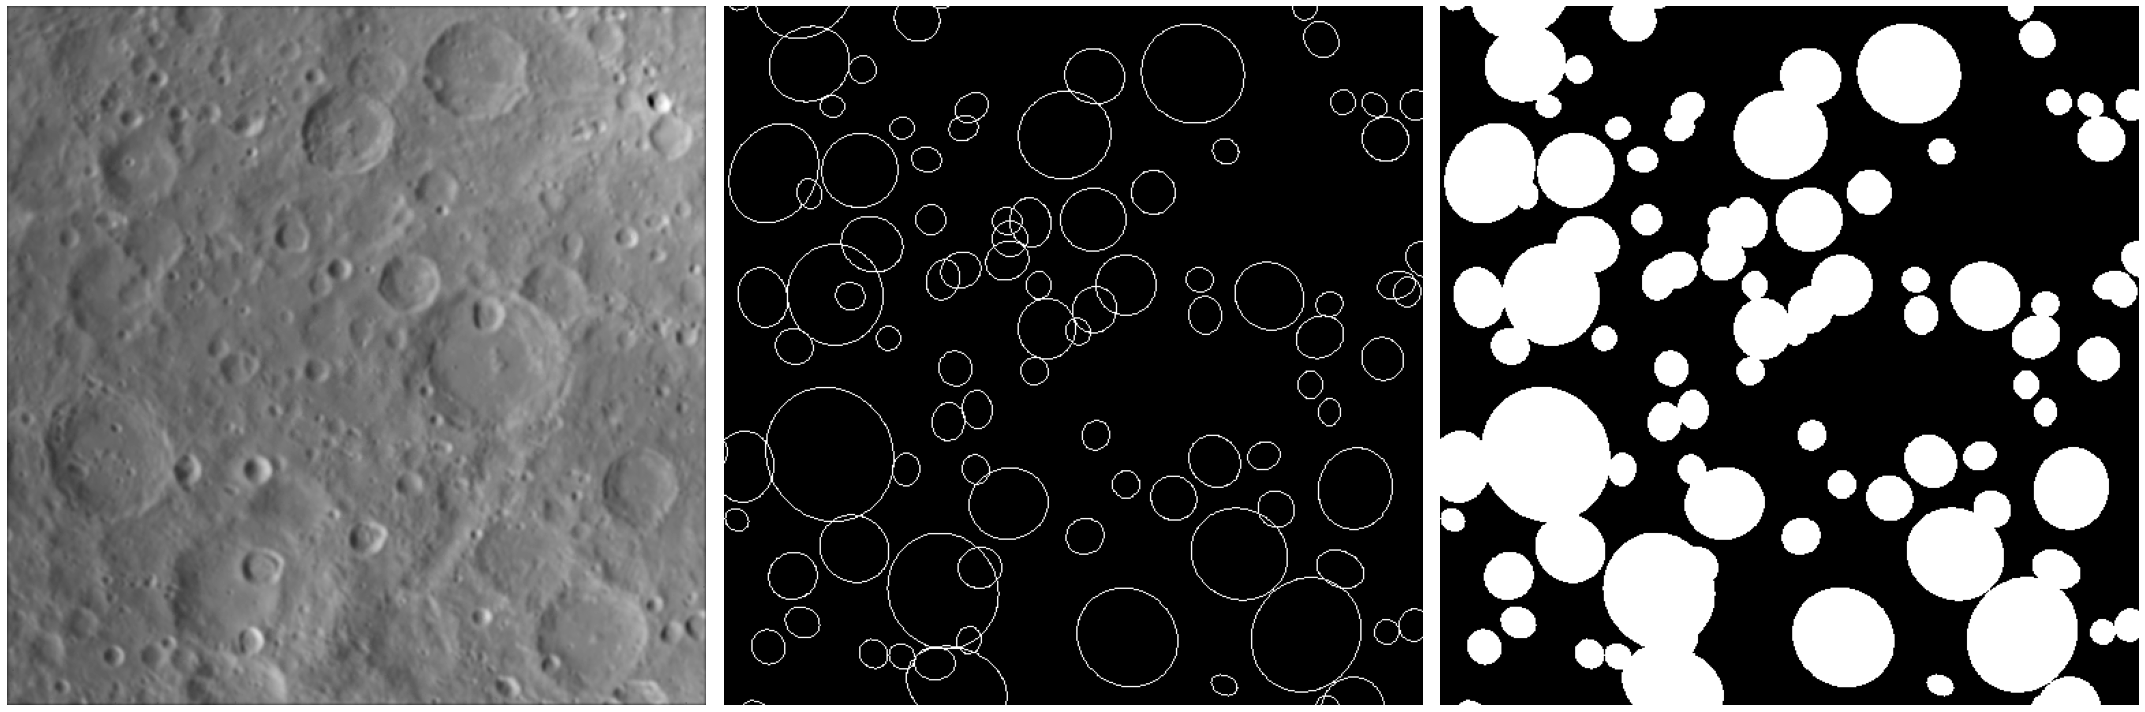

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(30, 10))

mask_demo_img, mask_edge = generator.image_mask_pair()
axes[0].imshow(mask_demo_img, cmap='gray')
axes[0].axis('off')


axes[1].imshow(mask_edge>0, cmap='gray')
axes[1].axis('off')

mask_filled = generator.generate_mask(filled=True)
axes[2].imshow(mask_filled>0, cmap='gray')
axes[2].axis('off')

fig.tight_layout()
fig.savefig('diagrams/image_mask_pair_demo.png')

In [1]:
from src.detection.model import CraterDetector
from src.detection.training import CraterEllipseDataset, CraterMaskDataset, collate_fn
from torch.utils.data import DataLoader

In [2]:
ds = CraterEllipseDataset(file_path="data/dataset_ellipse_reg_test.h5", group="training")
loader = DataLoader(ds, batch_size=8, shuffle=True, num_workers=0, collate_fn=collate_fn)
model = CraterDetector()

In [3]:
images, target = next(iter(loader))

In [5]:
model.eval()
out = model(images)

In [9]:
out[0]["boxes"].shape

torch.Size([100, 4])